In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import initializers as init
print(tf.__version__)

2.5.0


In [4]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [6]:
train_data.iloc[:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features = all_features.fillna(0)

In [11]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # (2919, 354)

(2919, 354)

In [12]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values,dtype=np.float)
test_features = np.array(all_features[n_train:].values,dtype=np.float)
train_labels = np.array(train_data.SalePrice.values.reshape(-1, 1),dtype=np.float)

In [15]:
def get_net():
    net = keras.models.Sequential()
    net.add(keras.layers.Dense(1))
    return net

In [14]:
log_rmse=tf.keras.losses.mean_squared_logarithmic_error

In [16]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], axis=0)
            y_train = tf.concat([y_train, y_part], axis=0)
    return X_train, y_train, X_valid, y_valid

In [17]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # create model
        data = get_k_fold_data(k, i, X_train, y_train)
        net=get_net()
        # Compile model
        net.compile(loss=tf.keras.losses.mean_squared_logarithmic_error, optimizer=tf.keras.optimizers.Adam(learning_rate))
        # Fit the model
        history=net.fit(data[0], data[1],validation_data=(data[2], data[3]), epochs=num_epochs, batch_size=batch_size,validation_freq=1,verbose=0)
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, loss[-1], val_loss[-1]))
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='valid')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


fold 0, train rmse 8.950552, valid rmse 9.123376
fold 1, train rmse 9.802516, valid rmse 9.892323
fold 2, train rmse 11.061989, valid rmse 11.142373
fold 3, train rmse 8.479453, valid rmse 8.300979
fold 4, train rmse 7.846452, valid rmse 7.917716


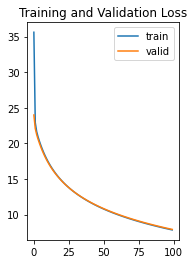

In [22]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
k_fold(k, train_features, train_labels, num_epochs,lr, weight_decay, batch_size)

In [20]:
x_train=tf.convert_to_tensor(train_features,dtype=tf.float32)
y_train=tf.convert_to_tensor(train_labels,dtype=tf.float32)
x_test=tf.convert_to_tensor(test_features,dtype=tf.float32)
model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(1)
])
adam=tf.keras.optimizers.Adam(0.5)
model.compile(
    optimizer=adam,
    loss=tf.keras.losses.mean_squared_logarithmic_error        
)
model.fit(x_train, y_train, epochs=200,batch_size=32,verbose=0)
preds=np.array(model.predict(x_test))
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)